In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from learntools.time_series.utils import plot_periodogram, seasonal_plot
from learntools.time_series.utils import plot_lags, make_lags, make_leads
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import DeterministicProcess
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import statsmodels.api as sm
import itertools
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sales-forecasting/train.csv


In [3]:
df = pd.read_csv('/kaggle/input/sales-forecasting/train.csv')
df.head(),df.shape

(   Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
 0       1  CA-2017-152156  08/11/2017  11/11/2017    Second Class    CG-12520   
 1       2  CA-2017-152156  08/11/2017  11/11/2017    Second Class    CG-12520   
 2       3  CA-2017-138688  12/06/2017  16/06/2017    Second Class    DV-13045   
 3       4  US-2016-108966  11/10/2016  18/10/2016  Standard Class    SO-20335   
 4       5  US-2016-108966  11/10/2016  18/10/2016  Standard Class    SO-20335   
 
      Customer Name    Segment        Country             City       State  \
 0      Claire Gute   Consumer  United States        Henderson    Kentucky   
 1      Claire Gute   Consumer  United States        Henderson    Kentucky   
 2  Darrin Van Huff  Corporate  United States      Los Angeles  California   
 3   Sean O'Donnell   Consumer  United States  Fort Lauderdale     Florida   
 4   Sean O'Donnell   Consumer  United States  Fort Lauderdale     Florida   
 
    Postal Code Region       Product

In [4]:
df['Order Date'] = pd.to_datetime(df['Order Date'],format = "%d/%m/%Y")
df.set_index('Order Date',inplace = True)

In [5]:
df = df.sort_values('Order Date')
df.shape

(9800, 17)

 Converted the order date column from 'object' to 'datetime' and then sorted the sales datewise

In [6]:
cols = ['Order ID','Row ID','Ship Date','Customer ID','Postal Code','Product ID','Product Name','Region']
df.drop(cols,axis = 1,inplace = True)


Dropped columns which were redundant or provided no info about sales next day.

In [7]:
df.head()

,Ship Mode,Customer Name,Segment,Country,City,State,Category,Sub-Category,Sales
Order Date,,,,,,,,,
2015-01-03,Standard Class,Darren Powers,Consumer,United States,Houston,Texas,Office Supplies,Paper,16.448
2015-01-04,Standard Class,Phillina Ober,Home Office,United States,Naperville,Illinois,Office Supplies,Binders,3.540
2015-01-04,Standard Class,Phillina Ober,Home Office,United States,Naperville,Illinois,Office Supplies,Storage,272.736
2015-01-04,Standard Class,Phillina Ober,Home Office,United States,Naperville,Illinois,Office Supplies,Labels,11.784
2015-01-05,Standard Class,Mick Brown,Consumer,United States,Philadelphia,Pennsylvania,Office Supplies,Art,19.536


In [8]:
cols = ['Ship Mode', 'Customer Name','Segment','Country',"City",'State','Category','Sub-Category']
label = LabelEncoder()
df['Category_Cat'] = label.fit_transform(df['Category'])
df['Ship Mode_Cat'] = label.fit_transform(df['Ship Mode'])
df['Sub-Category_Cat'] = label.fit_transform(df['Sub-Category'])
df['State_Cat'] = label.fit_transform(df['State'])
df['City_Cat'] = label.fit_transform(df['City'])
df['Country_Cat'] = label.fit_transform(df['Country'])
df['Customer Name_Cat'] = label.fit_transform(df['Customer Name'])
df['Segment_Cat'] = label.fit_transform(df['Segment'])
df.head()

,Ship Mode,Customer Name,Segment,Country,City,State,Category,Sub-Category,Sales,Category_Cat,Ship Mode_Cat,Sub-Category_Cat,State_Cat,City_Cat,Country_Cat,Customer Name_Cat,Segment_Cat
Order Date,,,,,,,,,,,,,,,,,
2015-01-03,Standard Class,Darren Powers,Consumer,United States,Houston,Texas,Office Supplies,Paper,16.448,1,3,12,41,207,0,198,0
2015-01-04,Standard Class,Phillina Ober,Home Office,United States,Naperville,Illinois,Office Supplies,Binders,3.540,1,3,3,11,319,0,611,2
2015-01-04,Standard Class,Phillina Ober,Home Office,United States,Naperville,Illinois,Office Supplies,Storage,272.736,1,3,14,11,319,0,611,2
2015-01-04,Standard Class,Phillina Ober,Home Office,United States,Naperville,Illinois,Office Supplies,Labels,11.784,1,3,10,11,319,0,611,2
2015-01-05,Standard Class,Mick Brown,Consumer,United States,Philadelphia,Pennsylvania,Office Supplies,Art,19.536,1,3,2,36,372,0,537,0


In [9]:
df.drop(cols,axis = 1,inplace = True)
df.head(),df.shape

(              Sales  Category_Cat  Ship Mode_Cat  Sub-Category_Cat  State_Cat  \
 Order Date                                                                      
 2015-01-03   16.448             1              3                12         41   
 2015-01-04    3.540             1              3                 3         11   
 2015-01-04  272.736             1              3                14         11   
 2015-01-04   11.784             1              3                10         11   
 2015-01-05   19.536             1              3                 2         36   
 
             City_Cat  Country_Cat  Customer Name_Cat  Segment_Cat  
 Order Date                                                         
 2015-01-03       207            0                198            0  
 2015-01-04       319            0                611            2  
 2015-01-04       319            0                611            2  
 2015-01-04       319            0                611            2  
 2015-01-0


Categorized all features

In [10]:
df.reset_index(inplace = True)
def mode(series):
    return series.mode()[0]
print(mode(df['City_Cat']))
def get_value_with_max_sales(group):
    # Get the row with the maximum sales value
    max_sales_idx = group['Sales'].idxmax()
    return group.loc[max_sales_idx]

# Group by 'Order Date' and apply the custom aggregation function
grouped = df.groupby('Order Date').apply(get_value_with_max_sales)

# Reset index to have 'Order Date' as a column again
grouped.reset_index(drop=True, inplace=True)

# Sum the sales for each 'Order Date'
sales_sum = df.groupby('Order Date')['Sales'].sum().reset_index()

# Merge the grouped data with the sales sum
data = pd.merge(grouped, sales_sum, on='Order Date', suffixes=('', '_total'))

# Keep necessary columns and rename 'Sales_total' back to 'Sales'
data = data[['Order Date', 'Category_Cat', 'Ship Mode_Cat', 'Sub-Category_Cat', 'State_Cat', 'City_Cat', 'Country_Cat', 'Customer Name_Cat', 'Segment_Cat', 'Sales_total']]
data.rename(columns={'Sales_total': 'Sales'}, inplace=True)
data

327


/tmp/ipykernel_33/3106988801.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df.groupby('Order Date').apply(get_value_with_max_sales)


,Order Date,Category_Cat,Ship Mode_Cat,Sub-Category_Cat,State_Cat,City_Cat,Country_Cat,Customer Name_Cat,Segment_Cat,Sales
0,2015-01-03,1,3,12,41,207,0,198,0,16.4480
1,2015-01-04,1,3,14,11,319,0,611,2,288.0600
2,2015-01-05,1,3,2,36,372,0,537,0,19.5360
3,2015-01-06,0,3,5,15,194,0,486,2,4407.1000
4,2015-01-07,0,3,9,41,209,0,785,0,87.1580
...,...,...,...,...,...,...,...,...,...,...
1225,2018-12-26,1,1,14,25,158,0,790,1,814.5940
1226,2018-12-27,2,1,13,33,328,0,190,1,177.6360
1227,2018-12-28,1,2,14,3,436,0,444,1,1657.3508
1228,2018-12-29,0,2,5,15,266,0,422,0,2915.5340


Here I have replaced all columns on the same date by that value which corresponds to the max sales on that particular day. As I was using a linear regression model I had to categorize for each variable and splitting all features would not be productive. Max sales will basically put more gravity to items which were sold in higher value that day.

In [11]:
data.set_index(data['Order Date'],inplace = True)
data.drop(['Order Date'],axis = 1,inplace = True)
data.tail()

,Category_Cat,Ship Mode_Cat,Sub-Category_Cat,State_Cat,City_Cat,Country_Cat,Customer Name_Cat,Segment_Cat,Sales
Order Date,,,,,,,,,
2018-12-26,1,1,14,25,158,0,790,1,814.5940
2018-12-27,2,1,13,33,328,0,190,1,177.6360
2018-12-28,1,2,14,3,436,0,444,1,1657.3508
2018-12-29,0,2,5,15,266,0,422,0,2915.5340
2018-12-30,0,3,4,30,327,0,589,0,713.7900


In [12]:
data.index = pd.to_datetime(data.index)
date_range = pd.date_range(start='2015-01-03', end='2018-12-30', freq='D')
date_range = pd.to_datetime(date_range)
data_reindexed = data.reindex(date_range)
data_filled_forward = data_reindexed.ffill()
data_filled_forward.shape,data.shape,date_range.shape
data_filled_forward

,Category_Cat,Ship Mode_Cat,Sub-Category_Cat,State_Cat,City_Cat,Country_Cat,Customer Name_Cat,Segment_Cat,Sales
2015-01-03,1.0,3.0,12.0,41.0,207.0,0.0,198.0,0.0,16.4480
2015-01-04,1.0,3.0,14.0,11.0,319.0,0.0,611.0,2.0,288.0600
2015-01-05,1.0,3.0,2.0,36.0,372.0,0.0,537.0,0.0,19.5360
2015-01-06,0.0,3.0,5.0,15.0,194.0,0.0,486.0,2.0,4407.1000
2015-01-07,0.0,3.0,9.0,41.0,209.0,0.0,785.0,0.0,87.1580
...,...,...,...,...,...,...,...,...,...
2018-12-26,1.0,1.0,14.0,25.0,158.0,0.0,790.0,1.0,814.5940
2018-12-27,2.0,1.0,13.0,33.0,328.0,0.0,190.0,1.0,177.6360
2018-12-28,1.0,2.0,14.0,3.0,436.0,0.0,444.0,1.0,1657.3508
2018-12-29,0.0,2.0,5.0,15.0,266.0,0.0,422.0,0.0,2915.5340


I imputed for missing datetime as it may have caused errors in measurement in linear regression. I used forward fill method which basically uses that value which was present on the previous day. Any other filling method would be preferred if there were more propotion of missing values.

<Axes: >

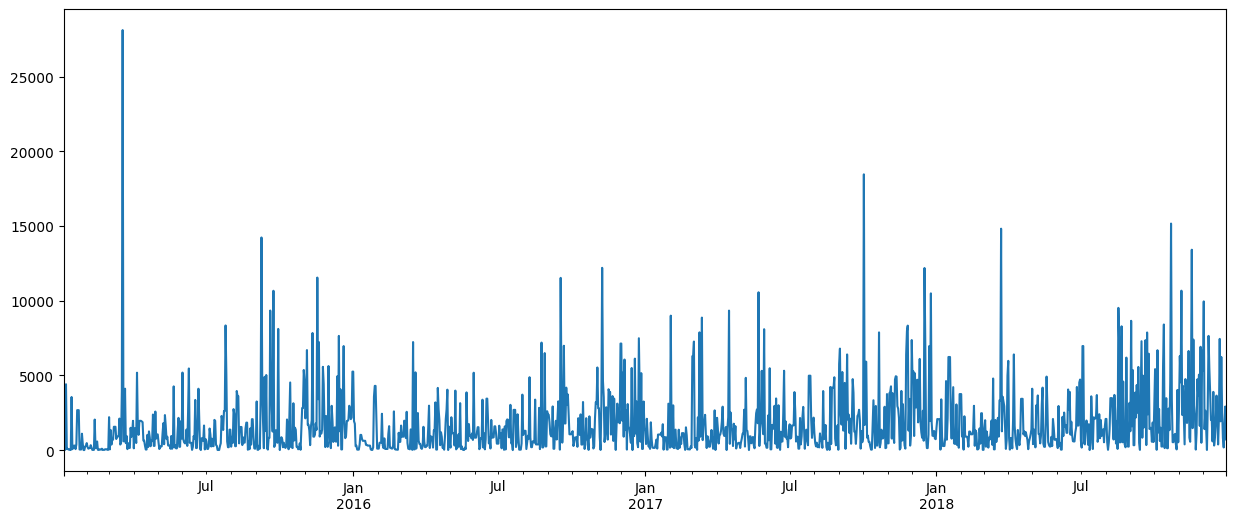

In [13]:
data_filled_forward['Sales'].plot(figsize = (15,6))

Although it is not visible however there is an increasing trend here.

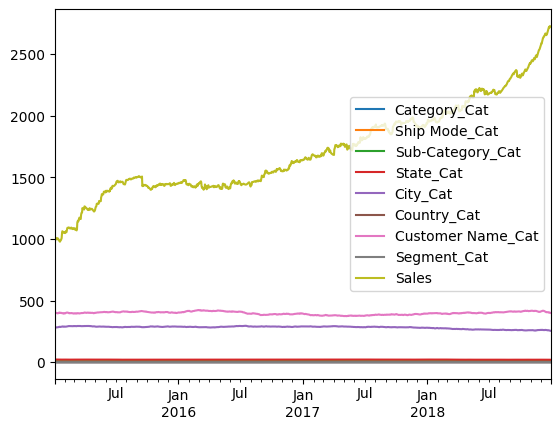

In [14]:
trend = data_filled_forward.rolling(
    window = 365,
    center = True,
    min_periods = 185
).mean()
ax = trend.plot()

As can be seen we can fit a quadratic trend to this sales dataset. Also the trend is yearly.

In [15]:
scaler = StandardScaler()
sales_reshaped = data_filled_forward['Sales'].values.reshape(-1, 1)
sales_scaled = scaler.fit_transform(sales_reshaped)
data_filled_forward['Sales_scaled'] = sales_scaled

In [16]:
data_filled_forward
data_filled_forward.drop(['Country_Cat','Sales'],axis=1,inplace = True)

In [27]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(data_filled_forward['Sales_scaled'],autolag = 'AIC')
print(dftest[0],dftest[1],dftest[2],dftest[3])
critical_values = dftest[4]
for key, value in critical_values.items():
    print(f'    {key}: {value}')

-6.251366350804222 4.445770426594561e-08 15 1442
    1%: -3.4348929812602784
    5%: -2.863546418485167
    10%: -2.5678382024888378


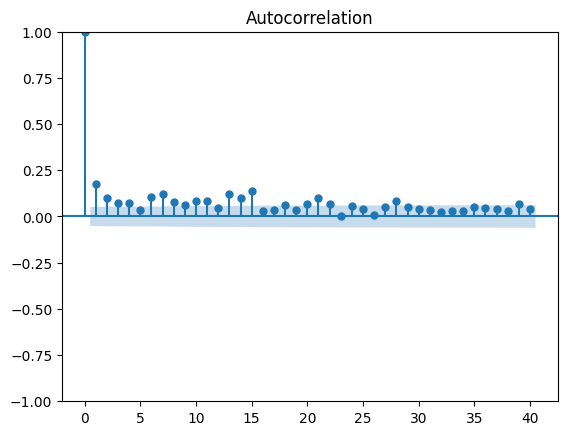

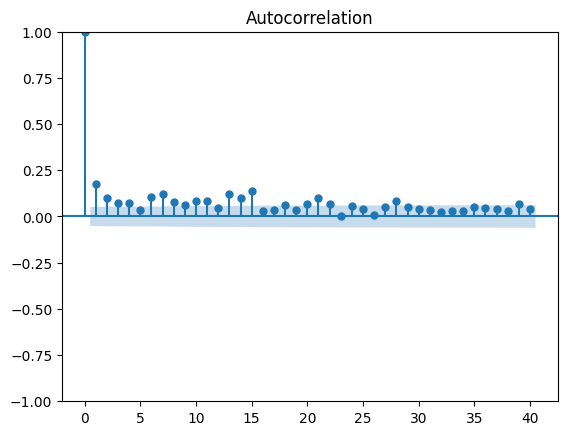

In [29]:
plot_acf(data_filled_forward['Sales_scaled'],lags = 40)

ADFuller statistics are used to see if there is stationarity in the curve and how many lags are needed to predict the sales. Here we can see that the p-value is very small implying stationarity and the number of lags required will be 15. pacf values are also used to check the factor of how much the previous values relate to the current. Uptill 15 we can see there is some correlation to the present value after that it decreases. Hence lags = 15

In [17]:
X_lag = make_lags(data_filled_forward['Sales_scaled'],lags = 15)
X = pd.concat([data_filled_forward,X_lag],axis = 1).dropna()
X.head()

,Category_Cat,Ship Mode_Cat,Sub-Category_Cat,State_Cat,City_Cat,Customer Name_Cat,Segment_Cat,Sales_scaled,y_lag_1,y_lag_2,...,y_lag_6,y_lag_7,y_lag_8,y_lag_9,y_lag_10,y_lag_11,y_lag_12,y_lag_13,y_lag_14,y_lag_15
2015-01-18,1.0,2.0,1.0,35.0,462.0,211.0,1.0,-0.757164,-0.650003,-0.650003,...,-0.782198,-0.782198,-0.761737,-0.768249,-0.747002,-0.747002,1.222059,-0.777824,-0.655429,-0.779232
2015-01-19,0.0,0.0,4.0,1.0,449.0,754.0,0.0,-0.614163,-0.757164,-0.650003,...,0.833117,-0.782198,-0.782198,-0.761737,-0.768249,-0.747002,-0.747002,1.222059,-0.777824,-0.655429
2015-01-20,0.0,3.0,5.0,2.0,220.0,334.0,0.0,0.432040,-0.614163,-0.757164,...,-0.758487,0.833117,-0.782198,-0.782198,-0.761737,-0.768249,-0.747002,-0.747002,1.222059,-0.777824
2015-01-21,0.0,3.0,5.0,2.0,220.0,334.0,0.0,0.432040,0.432040,-0.614163,...,-0.718381,-0.758487,0.833117,-0.782198,-0.782198,-0.761737,-0.768249,-0.747002,-0.747002,1.222059
2015-01-22,0.0,3.0,5.0,2.0,220.0,334.0,0.0,0.432040,0.432040,0.432040,...,-0.650003,-0.718381,-0.758487,0.833117,-0.782198,-0.782198,-0.761737,-0.768249,-0.747002,-0.747002


In [18]:
dp = DeterministicProcess(
    index = X.index,
    constant = True,
    order = 2,
    drop = True
)
tim = dp.in_sample()
tim.head()

,const,trend,trend_squared
2015-01-18,1.0,1.0,1.0
2015-01-19,1.0,2.0,4.0
2015-01-20,1.0,3.0,9.0
2015-01-21,1.0,4.0,16.0
2015-01-22,1.0,5.0,25.0


Basically we use the time trend to represent the growth in our sales with time. As we saw earlier it was quadratic hence we used order = 2.

In [19]:
tim_train,tim_test,y_train,y_test  =  train_test_split(tim,X['Sales_scaled'],test_size = 0.05,shuffle = False)
y_train = pd.Series.to_frame(y_train)
y_test = pd.Series.to_frame(y_test)
model1 = LinearRegression(fit_intercept = False)
model1.fit(tim_train,y_train)
y_fit = pd.DataFrame(model1.predict(tim_train),index = y_train.index,columns = y_train.columns)
y_pred = pd.DataFrame(
    model1.predict(tim_test),
    index=y_test.index,columns = y_test.columns
)

In [22]:
X_train,X_test = train_test_split(X,test_size = 0.05,shuffle = False)
model = XGBRegressor()
Y_train = y_train-y_fit
model.fit(X_train, Y_train)
Y_fit = pd.DataFrame(model.predict(X_train),index = X_train.index,columns = y_fit.columns)
Y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index,columns = y_pred.columns)
print(Y_pred)

            Sales_scaled
2018-10-19      0.469922
2018-10-20     -0.246860
2018-10-21      1.050924
2018-10-22      7.114749
2018-10-23      0.685796
...                  ...
2018-12-26     -0.561599
2018-12-27     -0.775667
2018-12-28     -0.014640
2018-12-29      0.515049
2018-12-30     -0.537767

[73 rows x 1 columns]


We split the trend part and lags part of our data. The trend part can be better captured by linear reggression or neural networks so we used linear regression there. For the lags part wwe used xgboost. Thus we used a hybrid model for our forecasting.

In [24]:

print(mean_squared_error(y_test,Y_pred + y_pred))

0.375422130861025


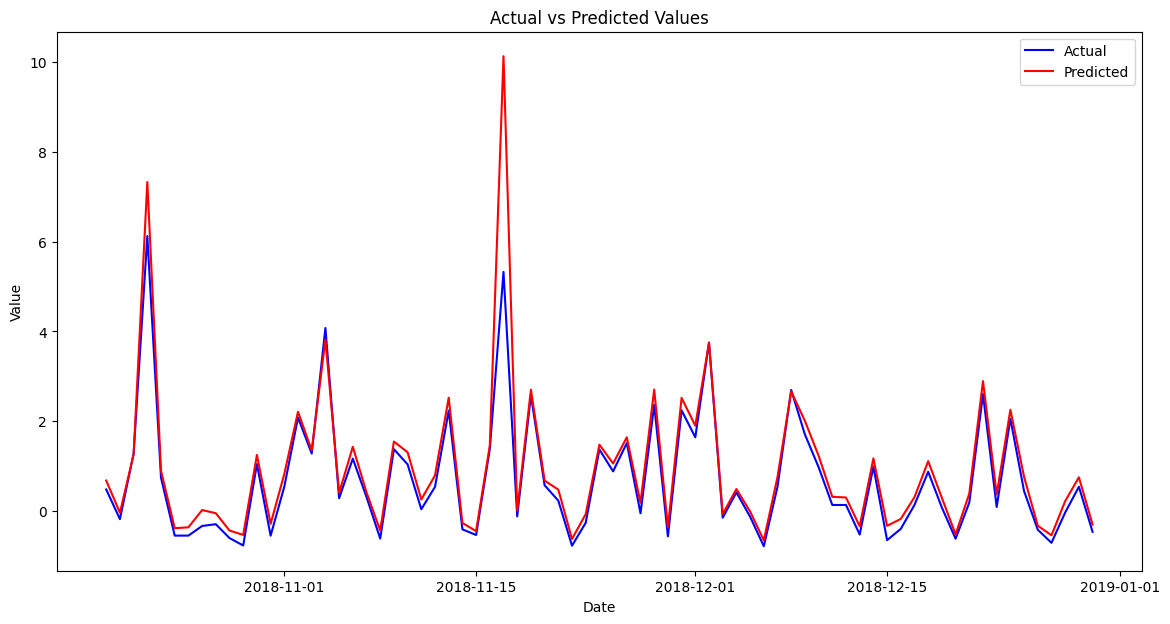

In [25]:
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Actual', color='blue')
plt.plot(y_test.index, y_pred + Y_pred, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()